# Using `load_stac` in openEO for accessing and analysing EO Data

Accessing and analyzing diverse, ever-growing datasets is a significant challenge in remote sensing. These datasets are often scattered across various sources, making them difficult to integrate. To address this issue, the openEO team introduced a new feature called [`load_stac`](https://open-eo.github.io/openeo-python-client/api-processes.html#openeo.processes.load_stac).

A recent [openEO notebook](https://github.com/Open-EO/openeo-community-examples/tree/main/python/LoadStac) demonstrates how to use the `load_stac` feature by creating an STAC item to integrate personal files. Using that notebook as a reference, here we explain how to retrieve similarly created external collections and combine them with existing datasets in the openEO ecosystem for basic analysis.


#### Establishing a connection to openEO

As the first step in using openEO, we will establish a connection to the openEO backend on the Copernicus Data Space Ecosystem (CDSE) and authenticate the session via OpenID Connect.

In [1]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


This step sets up the required connection to the CDSE backend.

#### Loading Collections

This example focuses on accessing external collections, so we simplify the analysis by calculating NDVI over a nearly 10-year period. Since Sentinel-2 data has only been available from 2015 onward, we chose to use Landsat-8 for the NDVI calculation. Although a subset of Landsat-8 data is already available in CDSE, we fetch it from the Microsoft Planetary Computer STAC to demonstrate how to work with external datasets.

Let us load Landsat-8 data for a specific location over the time range of 2014-2017. We will use the `load_stac` feature to access data from an external STAC source. Be sure to specify the bands and filter for Landsat-8 data accordingly.

Please note that `load_stac` reads data from external providers and writes it to the CDSE backend before processing. For large areas, this can lead to slower execution times and potentially higher costs. Therefore, it is advisable to use this feature cautiously by filtering for specific bands and limiting the spatial extent to avoid processing vast areas.

In [2]:
landsat= "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2"
landsat_cube = connection.load_stac(
        landsat,
        spatial_extent={"west": 5.0, "south": 51.21, "east": 5.05, "north": 51.25}, 
        temporal_extent=["2014-01-01", "2015-12-31"], 
        bands=["OLI_B4", "OLI_B5"],
        properties={
        "platform": lambda x: x=="landsat-8"}
    )

Failed to extract cube metadata from STAC URL https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2
Traceback (most recent call last):
  File "/opt/conda/envs/openeo/lib/python3.11/site-packages/openeo/rest/connection.py", line 1391, in load_stac
    cube.metadata = metadata_from_stac(url)
                    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/openeo/lib/python3.11/site-packages/openeo/metadata.py", line 584, in metadata_from_stac
    bands = list(_StacMetadataParser().get_bands_from_item_assets(collection.ext.item_assets))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/openeo/lib/python3.11/site-packages/openeo/metadata.py", line 669, in get_bands_from_item_assets
    asset_bands = self._get_bands_from_item_asset(item_asset, _warn=_warn)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/openeo/lib/python3.11/site-packages/openeo/m

Using `load_stac`, we could fetch data from an external provider (Microsoft Planetary Computer in this case) and filter it according to our requirements. Similarly, publicly available data stored in STAC collections or items can be accessed using this openEO feature for further analysis.

For the same spatial extent but with a different temporal range, we then load the Sentinel-2 collection directly from the CDSE. We select specific bands for NDVI calculation: Red (B04) and NIR (B08).

In [4]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2016-01-01", "2023-12-31"],
    spatial_extent={"west": 5.0, "south": 51.21, "east": 5.05, "north": 51.25},
    bands=["B04", "B08"]
)

This code snippet uses the `load_collection` function to access Sentin-2 data for the specified spatial and temporal extents, focusing on the bands required for NDVI analysis.

#### Compute NDVI for both datasets
Next, we compute the NDVI (Normalized Difference Vegetation Index) for both Sentinel-2 and Landsat-8 datasets.

In [5]:
# Compute NDVI for Landsat-8
landsat_cube = landsat_cube.ndvi(nir="OLI_B5", red="OLI_B4")

In [6]:
# Compute NDVI for Sentinel-2
s2_cube = s2_cube.ndvi()

The `.ndvi()` process in openEO is used here to compute the NDVI. While this process automatically identifies the NIR and Red bands for Sentinel-2, it is advisable to specify them explicitly. Additionally, users can also perform custom band math using simple mathematical operations.

#### Merge the collections

Once both NDVI datasets are prepared, we can merge them and aggregate the results over a specific period, such as daily, weekly, monthly, or seasonally, depending on your interest.

In [7]:
merged_cube = s2_cube.merge_cubes(landsat_cube)

#### Execute Batch Job and Save Output


"Finally, we execute the batch job and save the output to a file. For more information about batch jobs, visit [this lin(https://open-eo.github.io/openeo-python-client/batch_jobs.html)k."

In [13]:
job = merged_cube.execute_batch(title="Landsat8_Sen2_NDVI",outputfile="Merged_NDVI.nc")

0:00:00 Job 'j-240916db44c3476abb78b2712d685a03': send 'start'
0:00:15 Job 'j-240916db44c3476abb78b2712d685a03': created (progress 0%)
0:00:21 Job 'j-240916db44c3476abb78b2712d685a03': created (progress 0%)
0:00:27 Job 'j-240916db44c3476abb78b2712d685a03': created (progress 0%)
0:00:35 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:00:45 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:00:58 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:01:13 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:01:32 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:01:57 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:02:27 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:03:04 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:03:51 Job 'j-240916db44c3476abb78b2712d685a03': running (progress N/A)
0:04:50 Job 'j-240916db44c3476abb78b2712d685a03': running (progr

The execute_batch function runs the entire process and saves the resulting data to a file (`Merged_Landsat8Sen2.nc`) in NetCDF format, which can be used for further analysis or visualization.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

ndvi = xr.load_dataset("Merged_NDVI.nc")
ndvi

<xarray.Dataset> Size: 2GB
Dimensions:        (t: 1141, x: 363, y: 456)
Coordinates:
  * t              (t) datetime64[ns] 9kB 2014-01-04 2014-01-13 ... 2023-12-28
  * x              (x) float64 3kB 6.396e+05 6.396e+05 ... 6.432e+05 6.432e+05
  * y              (y) float64 4kB 5.68e+06 5.68e+06 ... 5.675e+06 5.675e+06
Data variables:
    crs            |S1 1B b''
    var            (t, y, x) float32 755MB nan nan nan ... 0.004835 0.00841
    unkown_band_1  (t, y, x) float32 755MB 0.05641 0.05791 0.05791 ... nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.40.1a1
    description:  
    title:

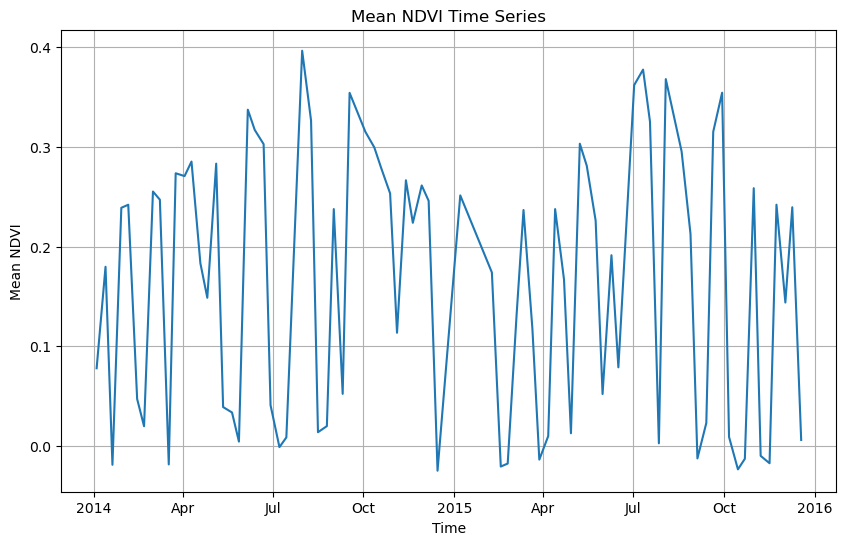

In [5]:
# Calculate the mean over the spatial dimensions and directly plot the result
ndvi['unkown_band_1'].mean(dim=['x', 'y']).plot(figsize=(10, 6))

# Customize the plot using Matplotlib features
plt.title('Mean NDVI Time Series')
plt.xlabel('Time')
plt.ylabel('Mean NDVI')
plt.grid(True)

plt.show()